<a href="https://colab.research.google.com/github/jayy1809/Neural-Net-from-Scratch/blob/main/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [194]:
import math
import numpy as np
import matplotlib.pyplot as plt


In [195]:
def f(x):
  return  3*x**2 - 2*x + 4

In [196]:
f(18.0)

940.0

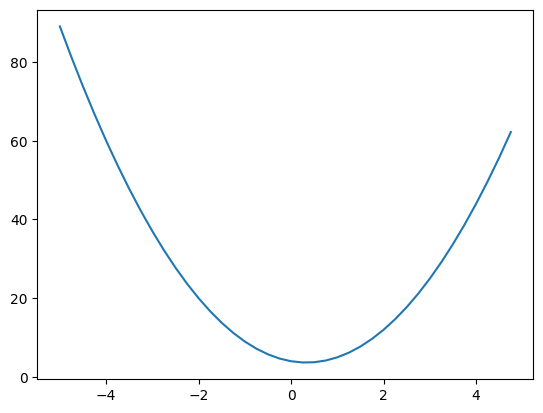

In [197]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [198]:
h = 0.001
x = 18.0

(f(x+h) - f(x))/h   # derivative

106.00300000021434

In [199]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [200]:
h = 0.000001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
a += h
d2 = a*b+c

print('d1', d1)
print('d2', d2)
print('slope ', (d2-d1)/h)

d1 4.0
d2 3.9999969999999996
slope  -3.000000000419334


In [201]:
class Value:
  def __init__(self,data, _children=(), _op='', label = ''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label


  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other),'+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other),'*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out


  def __pow__(self, other):
    assert isinstance(other,(int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other-1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self,other):
    # other = other if isinstance(other, Value) else Value(other)
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad = out.data * out.grad
    out._backward = _backward
    return out


  def backward(self):

    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [202]:
a = Value(1.0, label='a')
b = Value(2.0, label='b')
c = Value(3.0, label='c')

In [203]:
print(a)
a+b

Value(data=1.0)


Value(data=3.0)

In [204]:
a.__mul__(b).__add__(b)

Value(data=4.0)

In [205]:
d = a*b + c

In [206]:
d._prev #Children of d

{Value(data=2.0), Value(data=3.0)}

In [207]:
d._op

'+'

In [208]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR : left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))

    dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')

    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

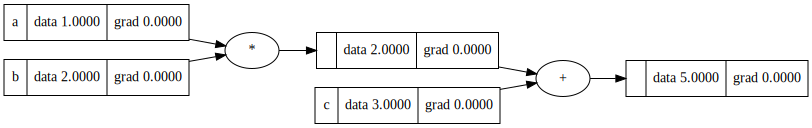

In [209]:
draw_dot(d)

In [210]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')


w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.8813735270, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o' #output


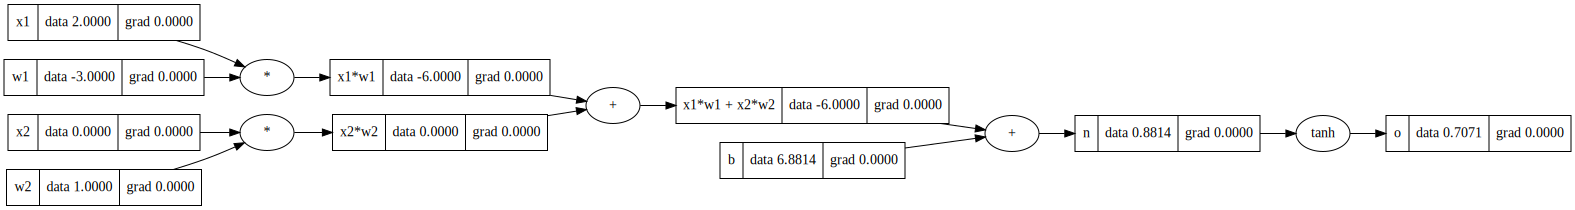

In [211]:
draw_dot(o)


In [212]:
o.grad = 1.0


In [213]:
# derivative of tanh is (1 - tanhx)^2

In [214]:
o.data

0.7071067511767748

In [215]:
1 - o.data**2

0.5000000424402267

In [216]:
n.grad = 0.5

In [217]:
x1w1x2w2.grad = 0.5
b.grad=0.5

In [218]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [219]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [220]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

TILL THIS WAS MANUALLY

full auto

In [221]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')


w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.8813735270, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o' #output


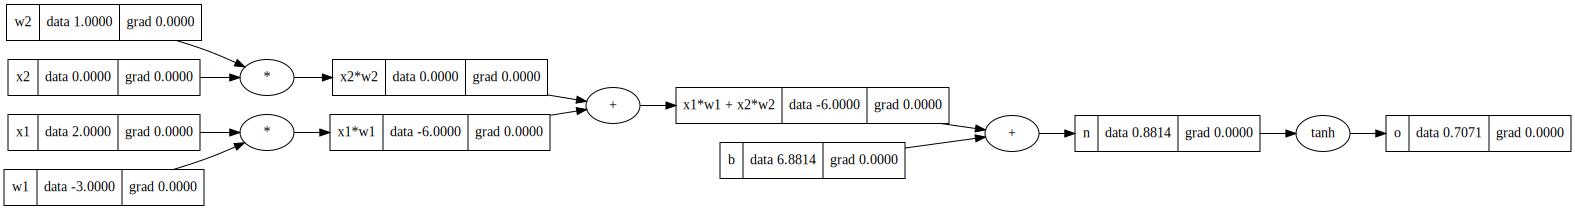

In [222]:
draw_dot(o)


In [223]:
o.grad = 1.0

In [224]:
o._backward()

In [225]:
n._backward()

In [226]:
b._backward()

In [227]:
x1w1x2w2._backward()

In [228]:
x2w2._backward()
x1w1._backward()

In [229]:
# TOPOLOGICAL SORT

topo = []
visited = set()

def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

build_topo(o)
topo

[Value(data=6.881373527),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.881373527),
 Value(data=0.7071067511767748)]

In [230]:
# so overall backpropogation will look like this

o.grad = 1.0

topo = []
visited = set()

def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

build_topo(o)

for node in reversed(topo):
  node._backward()

In [231]:
# now the actual backpropogation function
o.backward()

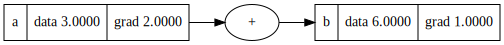

In [232]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

In [233]:
a = Value(2.0)
a+2

Value(data=4.0)

In [234]:
a-2
b = Value(2.0)
a/b

Value(data=1.0)

In [235]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')


w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.8813735270, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'
o.backward()

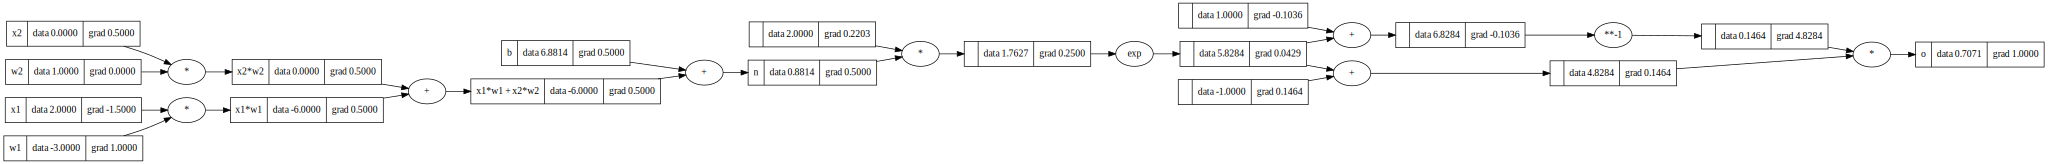

In [236]:
draw_dot(o)

In [237]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True

w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([6.88137]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071050214706146
x2 0.5000024886110417
w2 0.0
x1 -1.500007465833125
w1 1.0000049772220834


In [238]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [239]:
import random

In [240]:
class Neuron:
  def __init__(self, nin): # nin is number of input
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w*x + b
    act = sum((wi*xi for wi, xi in  zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]



class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]



class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts)) ]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [241]:
x = [2.0 , 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.8905974829014993)

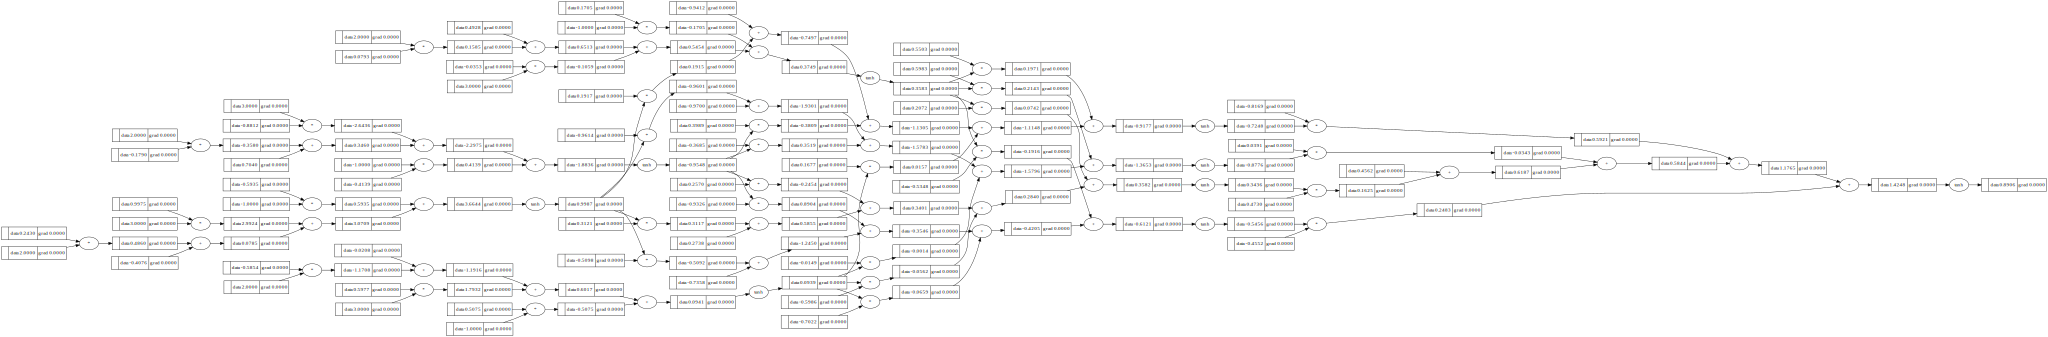

In [242]:
draw_dot(n(x))

In [335]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]


In [336]:
ys =[1.0, -1.0 , -1.0, 1.0] # desired targets

In [337]:
ypred = [n(x) for x in xs]

In [338]:
ypred

[Value(data=0.0462395805358591),
 Value(data=-0.7954417982506682),
 Value(data=-0.9996666069136437),
 Value(data=0.9368764998726636)]

In [339]:
loss = [(yout - ygroundtruth)**2 for ygroundtruth , yout in zip(ys,ypred)]

In [340]:
loss


[Value(data=0.909658937736414),
 Value(data=0.04184405790292034),
 Value(data=1.1115095003015972e-07),
 Value(data=0.003984576268325834)]

In [341]:
loss = sum(loss, Value(0))

In [342]:
loss

Value(data=0.9554876830586102)

In [343]:
loss.backward()

In [344]:
n.layers[0].neurons[0].w[0].grad

-0.29745778072148

In [345]:
n.layers[0].neurons[0].w[0].data

-0.1889550525484556

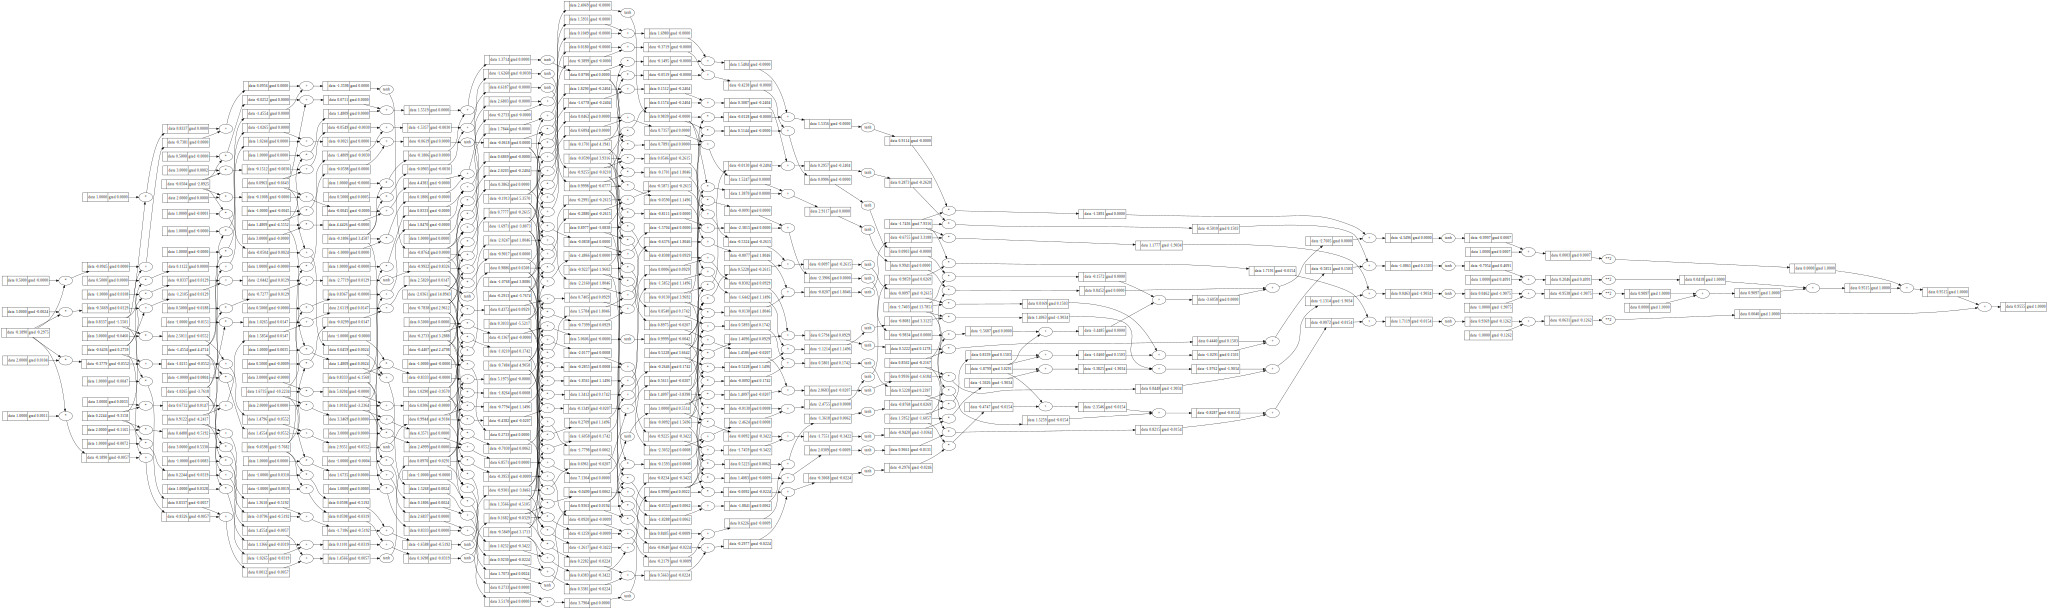

In [346]:
draw_dot(loss)

In [347]:
n.parameters()

[Value(data=-0.1889550525484556),
 Value(data=0.8337096093892332),
 Value(data=-1.4554434141517616),
 Value(data=-0.6436039979668987),
 Value(data=0.22438741141789623),
 Value(data=-1.02652014915554),
 Value(data=-0.05975088486869556),
 Value(data=0.9122054183990963),
 Value(data=-0.05038550041761984),
 Value(data=1.4808579679485294),
 Value(data=-0.18057605761609807),
 Value(data=0.09627977352204889),
 Value(data=1.6734508768769394),
 Value(data=0.8333108939279407),
 Value(data=-0.27334819848031044),
 Value(data=1.0102438236339624),
 Value(data=1.0289714374615866),
 Value(data=1.3566013626348143),
 Value(data=-0.922722307223503),
 Value(data=-0.009202694221106342),
 Value(data=-0.5848633245807873),
 Value(data=-0.7837645159778268),
 Value(data=-0.29127423300575284),
 Value(data=-0.05902467074116259),
 Value(data=0.522799648698761),
 Value(data=-1.076765669883009),
 Value(data=-0.4406669611327772),
 Value(data=-0.7484209213249648),
 Value(data=0.8976709875061936),
 Value(data=1.4096919

In [348]:
len(n.parameters())

41

In [349]:
for p in n.parameters():
  p.data += -0.01 * p.grad # 0.01 is Learning rate


In [350]:
n.layers[0].neurons[0].w[0].data

-0.1859804747412408

In [358]:
ypred = [n(x) for x in xs]
loss = [(yout - ygroundtruth)**2 for ygroundtruth , yout in zip(ys,ypred)]
loss = sum(loss, Value(0))
loss

Value(data=0.006452445342233665)

In [356]:
loss.backward()

In [357]:
for p in n.parameters():
  p.data += -0.01 * p.grad # 0.01 is Learning rate


**HENCE THE LOSS IS DECREASE AS YOU CAN SEE**

*earlier loss was 3.1*


*epoch 2 : then it is 3.0*


*epoch 3 : 1.6*


*epoch 4 : 0.86*


*after certain epochs the loss came down to 0.006 and our predictions are quite accurate and close to target *


In [359]:
ypred

[Value(data=0.9316085905194135),
 Value(data=-0.9580144548943051),
 Value(data=-0.9970921574801902),
 Value(data=0.9980457979761413)]

In [365]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum(((yout - ygroundtruth)**2 for ygroundtruth, yout in zip(ys, ypred)), Value(0))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.01 * p.grad

  print(k, loss.data)

0 1.9043396132845432e-05
1 1.903498853715625e-05
2 1.9026588086670277e-05
3 1.901819477241711e-05
4 1.90098085854353e-05
5 1.9001429516787845e-05
6 1.8993057557546676e-05
7 1.8984692698798447e-05
8 1.8976334931648394e-05
9 1.8967984247210636e-05
10 1.8959640636620747e-05
11 1.8951304091024126e-05
12 1.894297460158178e-05
13 1.8934652159469347e-05
14 1.892633675587998e-05
15 1.8918028382018528e-05
16 1.890972702910249e-05
17 1.8901432688367795e-05
18 1.889314535106396e-05
19 1.888486500845309e-05


In [366]:
ypred

[Value(data=0.9999999999974303),
 Value(data=-0.9999999996273828),
 Value(data=-0.9956543280141671),
 Value(data=0.9999999999974173)]